# 04a - Modelling

__Goal__: 
- Test some linear models (logistic regression, linear SVM) and nonlinear models (SVM with RBF kernel, decision tree, random forest)
- We select the best model on "validation" metrics, and provide its score on "test" metrics.
- 1 means "rain", 0 means "no rain".
- Working when raining is prejudical. We want to predict as much true "rain" as possible.
- High recall means you less often ask the docker to work during a rainy day.  This causes higher management costs.
- High precision means you don't ask the docker to stay at home while the weather is good. This causes higher delays in delivery.
- The f1-score is a trade-off between precision  and recall.
- The `normalize` parameter `{"true", "pred", "all"}` in `confusin_matrix_evaluation()` normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If `None`, confusion matrix will not be normalized.

1. Logistic regression
2. Linear SVC
3. SVC with RBF kernel
4. Decision Tree
5. Random Forest
6. Test metrics consistancy with pikled pipelines and  models

### Import

In [1]:
%load_ext autoreload
%autoreload 2
import joblib
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from weather.transformers.skl_transformer_makers import (
    FeatureNames,
    TargetChoice,
    make_dataset_ingestion_transformer,
    make_target_creation_transformer,
    make_remove_horizonless_rows_transformer, 
    make_predictors_feature_engineering_transformer,
)
from weather.data.prep_datasets import (
    prepare_binary_classification_tabular_data, 
    transform_dataset_and_create_target,
)
from weather.helpers.utils import camel_to_snake
from weather.models.skl_train_models import (
    score_evaluation,
    confusion_matrix_evaluation,
    confusion_matrix_display,
)

### Set the directory paths

In [2]:
data_dir =  Path.cwd().parent / "data"
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)

# 1. Prepare the `dataset` for modelization

### Select the predictors and set the target

In [3]:
# Select the predictors
feature_names = FeatureNames(
    numerical=[
        "Temperature",
        "Humidity",
        "Wind_speed",
        "Wind_bearing",
        "Visibility",
        "Pressure",
    ],
    categorical=[],  # Add or remove "Weather", "Month" to the predictors
)

# Set "Weather" within 4 hours as target
target_name = "Weather"
horizon = 4
target_choice = TargetChoice(target_name, horizon) 

### Set the dataset transformers

In [4]:
oldnames_newnames_dict = {
    "Temperature_C": "Temperature", 
    "Apparent_Temperature_C": "Apparent_temperature",
    "Wind_speed_kmph": "Wind_speed",
    "Wind_bearing_degrees": "Wind_bearing",
    "Visibility_km": "Visibility",
    "Pressure_millibars": "Pressure",
    "Weather_conditions": "Weather"}

dataset_ingestion_transformer = make_dataset_ingestion_transformer(target_choice, oldnames_newnames_dict)
remove_horizonless_rows_transformer = make_remove_horizonless_rows_transformer(target_choice)
target_creation_transformer = make_target_creation_transformer(target_choice)                       
predictors_feature_engineering_transformer = make_predictors_feature_engineering_transformer(feature_names, target_choice)

### Read the data

In [5]:
df = pd.read_csv(data_dir / 'weather_dataset_raw_development.csv')
df.head(1)

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Weather_conditions
0,2881,2006-01-01 00:00:00+00:00,"Port of Turku, Finland",1.161111,-3.238889,0.85,16.6152,139,9.9015,1016.15,rain


### Transform the dataset and split it

In [6]:
# Three transformers: "dataset__ingestion_transformer", "remove_horizonless_rows_transformer", "target_creation_transformer"
transformed_data, created_target = transform_dataset_and_create_target(
    df,   
    dataset_ingestion_transformer,
    remove_horizonless_rows_transformer,
    target_creation_transformer,
)

# Split the dataset
dataset = prepare_binary_classification_tabular_data(
    transformed_data,
    created_target,
)

In [7]:
len(dataset.train_x), len(dataset.val_x), len (dataset.test_x), len(dataset.train_y), len(dataset.val_y), len(dataset.test_y)
# (30673, 4382, 8765, 30673, 4382, 8765)

(30673, 4382, 8765, 30673, 4382, 8765)

# 2. Model the dataset

### Define candidate models

In [8]:
random_state = 1234

models = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(max_depth=4, random_state=random_state),
    },
    "LinearSvc": {
        "model": LinearSVC(max_iter=10_000, random_state=random_state),
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
    },
    "RandomForest": {
        "model": RandomForestClassifier(max_depth=4, random_state=random_state),
        #"param_grid": {"model__n_estimators": [5, 10], "model__max_depth": [None, 5, 10]},
    },
    "SvcWithRbfKernel": {
        "model": SVC(kernel="rbf", gamma=0.7, random_state=0),
    },
}

### Set metrics parameters

In [9]:
normalize = "all"  # for confusion matrices

###  1 -  `LogisticRegression`

Score(score_name='accuracy_score', train=0.895, val=0.883, test=0.86)
Score(score_name='precision_score', train=0.899, val=0.882, test=0.856)
Score(score_name='recall_score', train=0.986, val=0.999, test=0.997)
Score(score_name='f1_score', train=0.94, val=0.937, test=0.921)


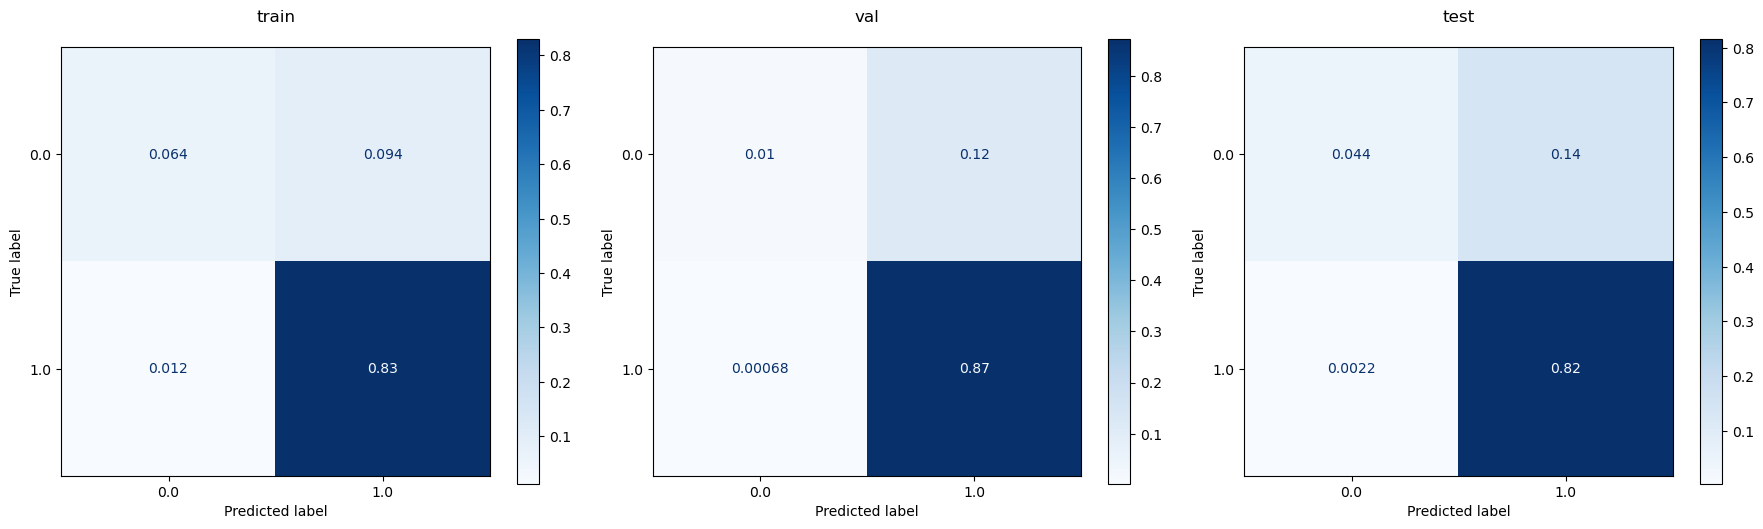

In [10]:
model_name = "LogisticRegression"
model = models[model_name]["model"]

# Train the model
model.fit(predictors_feature_engineering_transformer.fit_transform(dataset.train_x), dataset.train_y) # apply fit and transform, successively

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Set the path for persistance
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)

# Persist the four transformers and the model
joblib.dump(dataset_ingestion_transformer, model_subdir / "dataset_ingestion_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 2 - `LinearSvc`

Score(score_name='accuracy_score', train=0.884, val=0.878, test=0.847)
Score(score_name='precision_score', train=0.884, val=0.878, test=0.844)
Score(score_name='recall_score', train=0.992, val=1.0, test=0.999)
Score(score_name='f1_score', train=0.935, val=0.935, test=0.915)


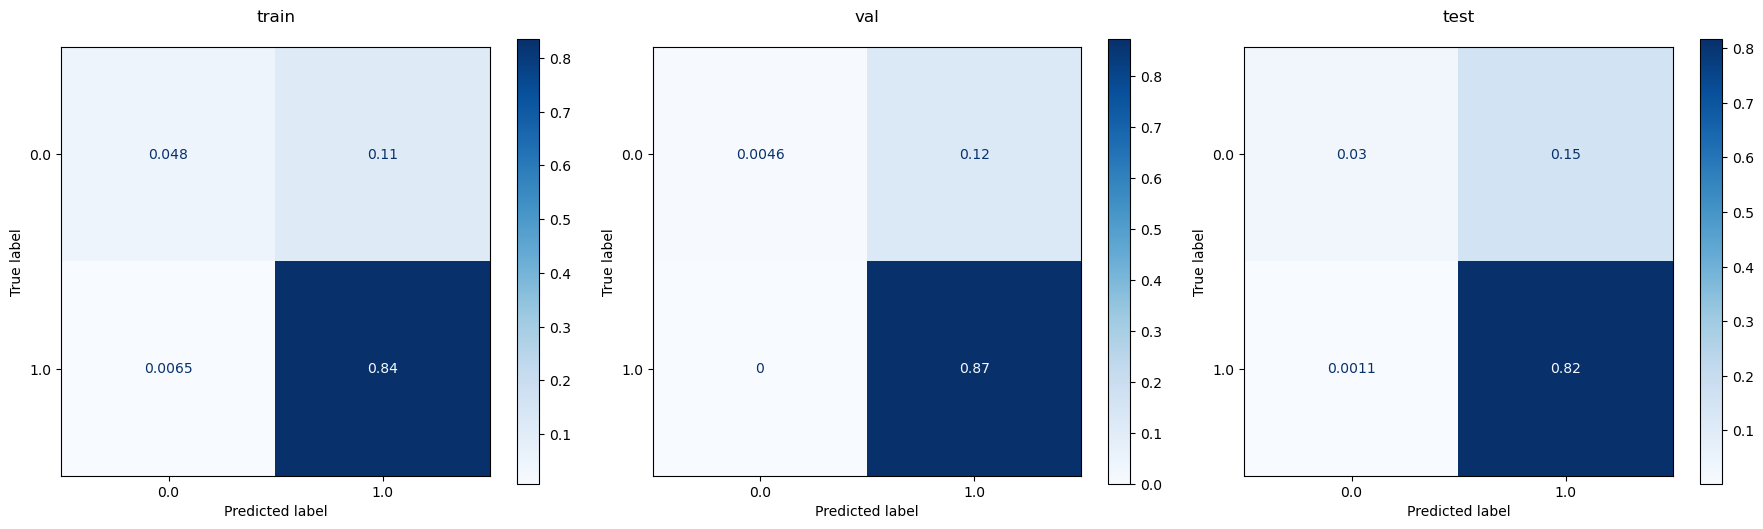

In [11]:
model_name = "LinearSvc"
model = models[model_name]["model"]

# Train the model
model.fit(predictors_feature_engineering_transformer.fit_transform(dataset.train_x), dataset.train_y) # apply fit and transform, successively

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Set the path for persistance
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)

# Persist the four transformers and the model
joblib.dump(dataset_ingestion_transformer, model_subdir / "dataset_ingestion_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 3 - `SvcWithRbfKernel` 

In [12]:
# model_name = "SvcWithRbfKernel"
# model = models[model_name]["model"]

# # Train the model
# model.fit(predictors_feature_engineering_transformer.fit_transform(dataset.train_x), dataset.train_y) # apply fit and transform, successively

# # Evaluate and display metrics
# print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
# print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
# print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
# print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# # Evalutate and display CM
# cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
# confusion_matrix_display(cm_results, model)

# # Set the path for persistance
# model_subdir  = models_dir / camel_to_snake(model_name)
# model_subdir.mkdir(exist_ok=True)

# # Persist the four transformers and the model
# joblib.dump(dataset_ingestion_transformer, model_subdir / "dataset_ingestion_pipeline.pkl")
# joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_pipeline.pkl")
# joblib.dump(target_creation_transformer, model_subdir / "target_creation_pipeline.pkl")
# joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
# joblib.dump(model, model_subdir / "model.pkl");

### 4 - `DecisionTree`

Score(score_name='accuracy_score', train=0.915, val=0.915, test=0.912)
Score(score_name='precision_score', train=0.927, val=0.915, test=0.921)
Score(score_name='recall_score', train=0.976, val=0.995, test=0.975)
Score(score_name='f1_score', train=0.951, val=0.954, test=0.948)


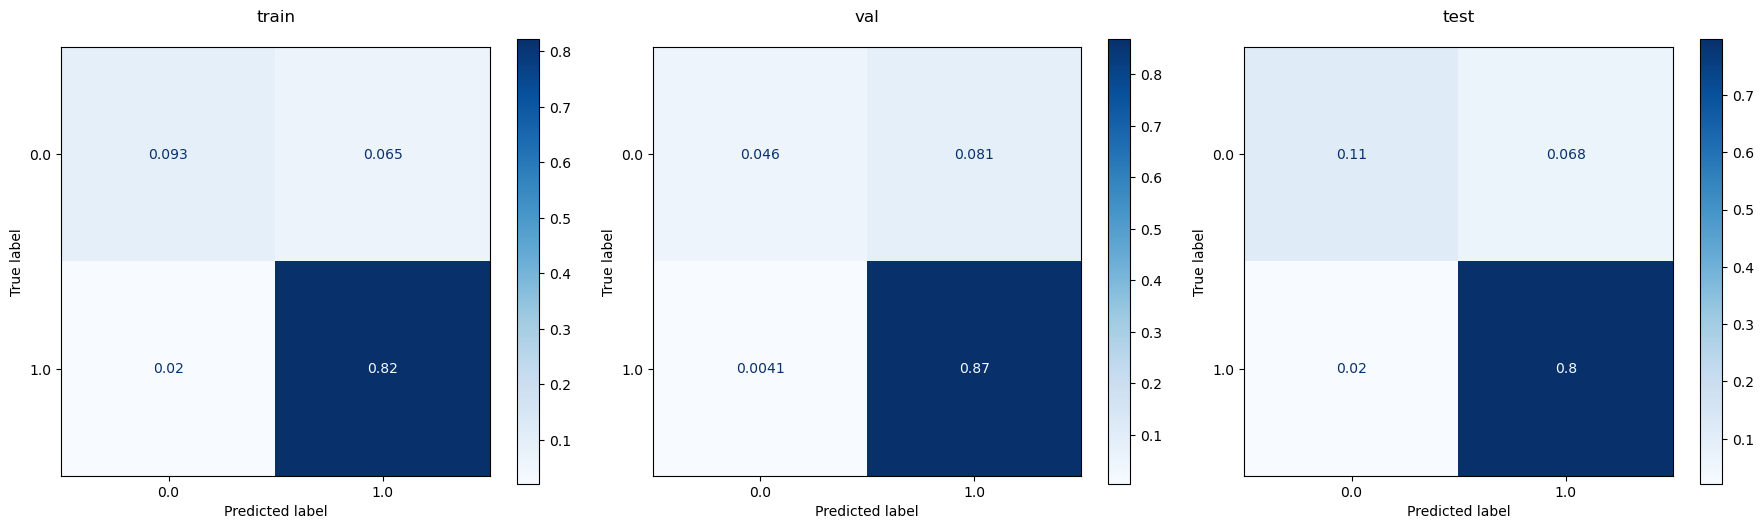

In [13]:
model_name = "DecisionTree"
model = models[model_name]["model"]

# Train the model
model.fit(predictors_feature_engineering_transformer.fit_transform(dataset.train_x), dataset.train_y) # apply fit and transform, successively

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Set the path for persistance
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)

# Persist the four transformers and the model
joblib.dump(dataset_ingestion_transformer, model_subdir / "dataset_ingestion_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 5 - `RandomForest`

Score(score_name='accuracy_score', train=0.917, val=0.918, test=0.926)
Score(score_name='precision_score', train=0.931, val=0.919, test=0.938)
Score(score_name='recall_score', train=0.974, val=0.993, test=0.974)
Score(score_name='f1_score', train=0.952, val=0.955, test=0.956)


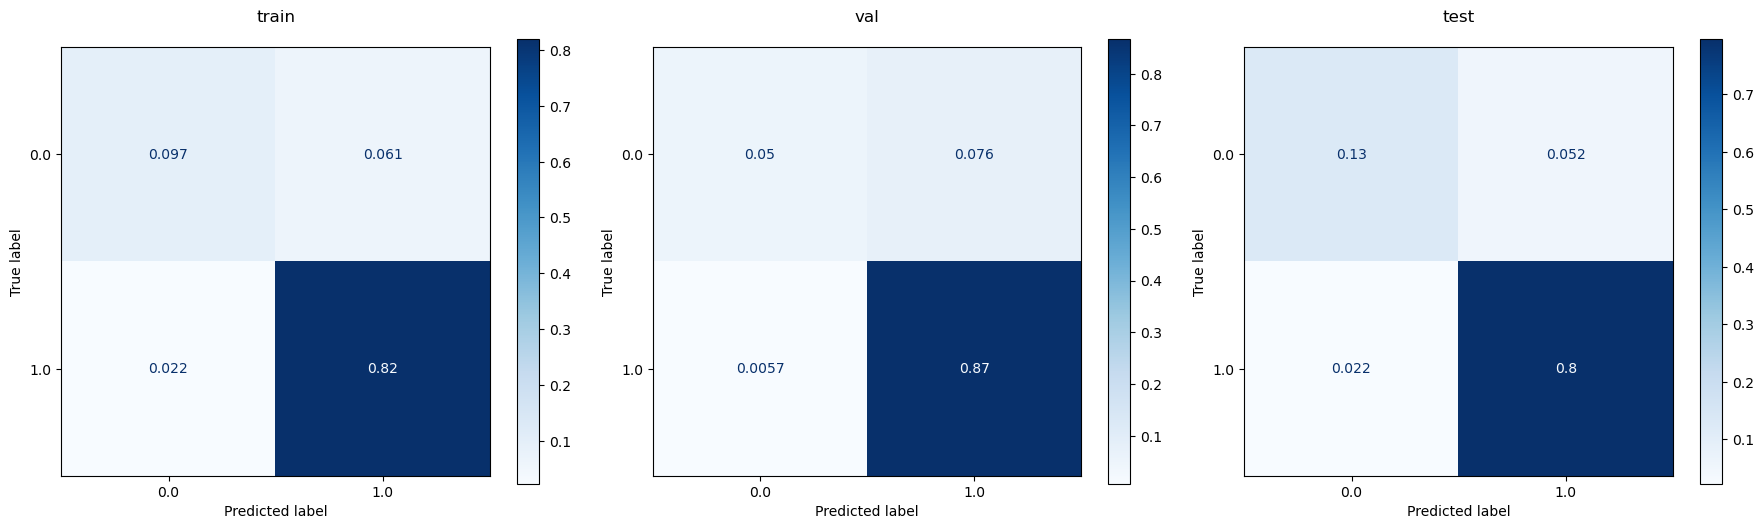

In [14]:
model_name = "RandomForest"
model = models[model_name]["model"]

# Train the model
model.fit(predictors_feature_engineering_transformer.fit_transform(dataset.train_x), dataset.train_y) # apply fit and transform, successively

# Evaluate and display metrics
print(score_evaluation(accuracy_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(precision_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(recall_score, predictors_feature_engineering_transformer, model, dataset))
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset))

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)

# Set the path for persistance
model_subdir  = models_dir / camel_to_snake(model_name)
model_subdir.mkdir(exist_ok=True)

# Persist the four transformers and the model
joblib.dump(dataset_ingestion_transformer, model_subdir / "dataset_ingestion_pipeline.pkl")
joblib.dump(remove_horizonless_rows_transformer, model_subdir / "remove_horizonless_rows_pipeline.pkl")
joblib.dump(target_creation_transformer, model_subdir / "target_creation_pipeline.pkl")
joblib.dump(predictors_feature_engineering_transformer, model_subdir / "predictors_feature_eng_pipeline.pkl")
joblib.dump(model, model_subdir / "model.pkl");

### 6. Test metrics consistancy with pikled pipelines and  models

In [15]:
# Load the four transformers and the trained model
dataset_transformer = joblib.load(model_subdir / "dataset_ingestion_pipeline.pkl")
remove_horizonless_rows_transformer = joblib.load(model_subdir / "remove_horizonless_rows_pipeline.pkl")
target_creation_transformer = joblib.load(model_subdir / "target_creation_pipeline.pkl")
predictors_feature_engineering_transformer =joblib.load(model_subdir / "predictors_feature_eng_pipeline.pkl")
model = joblib.load(model_subdir / "model.pkl")

### Transform the dataset and split it

In [16]:
# Transform
transformed_data, created_target = transform_dataset_and_create_target(
    df,   
    dataset_ingestion_transformer,
    remove_horizonless_rows_transformer,
    target_creation_transformer,
)

# Split
dataset = prepare_binary_classification_tabular_data(
    transformed_data,
    created_target,
)

### Display `f1-score` and confusion matrix

Score(score_name='f1_score', train=0.952, val=0.955, test=0.956) 



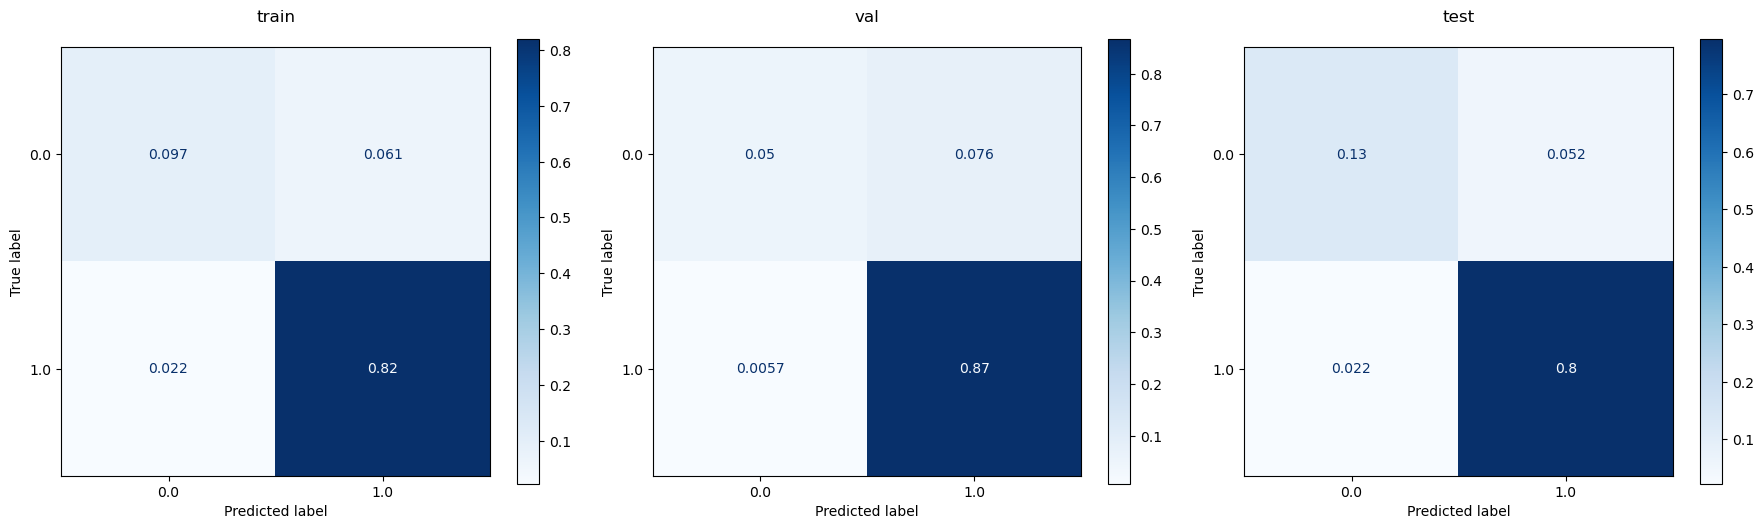

In [17]:
# `f1-score`
print(score_evaluation(f1_score, predictors_feature_engineering_transformer, model, dataset), "\n")

# Evalutate and display CM
cm_results = confusion_matrix_evaluation(predictors_feature_engineering_transformer, model, dataset, normalize=normalize)
confusion_matrix_display(cm_results, model)